In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import QuantileTransformer, StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize

### **Data Loading**

In [ ]:
# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [ ]:
# Load datasets
traffic_df = pd.read_csv('/content/Traffic.csv')
traffic_two_month_df = pd.read_csv('/content/TrafficTwoMonth.csv')

In [ ]:
traffic_df.head(3)

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low


In [ ]:
traffic_df['Traffic Situation'].value_counts()

,count
Traffic Situation,
normal,1669
heavy,682
high,321
low,304


In [ ]:
# Combine datasets
traffic_df['Source'] = 'OneMonth'
traffic_two_month_df['Source'] = 'TwoMonth'
combined_df = pd.concat([traffic_df, traffic_two_month_df], ignore_index=True)

In [ ]:
combined_df.shape

(8928, 10)

## **Exploratory Data Analysis (EDA)**

In [ ]:
#Distribution of vehicle counts for cars, bikes, buses, and trucks
fig = make_subplots(rows=2, cols=2, subplot_titles=("Car Counts", "Bike Counts", "Bus Counts", "Truck Counts"))

fig.add_trace(go.Histogram(x=combined_df['CarCount'], name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Histogram(x=combined_df['BikeCount'], name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Histogram(x=combined_df['BusCount'], name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Histogram(x=combined_df['TruckCount'], name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Distribution of Vehicle Counts', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Count")
fig.update_yaxes(title_text="Frequency")
fig.show()

In [ ]:
# Distribution of traffic situations
fig = px.pie(combined_df, names='Traffic Situation', title='Traffic Situation Distribution', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text='Traffic Situation Distribution', title_x=0.5, template='plotly_white')
fig.show()

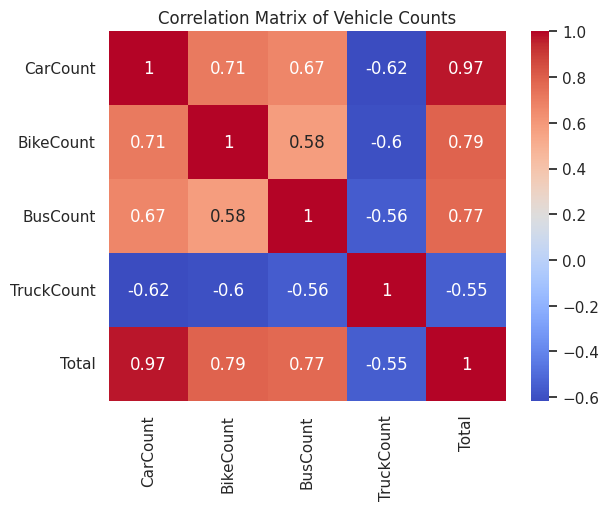

In [ ]:
#Correlations between different vehicle types
corr_matrix = combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Vehicle Counts')
plt.show()

# **Data Preprocessing**

In [ ]:
# Remove outliers using IQR method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df
vehicle_cols = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']
combined_df = remove_outliers(combined_df, vehicle_cols)

In [ ]:
 #Check for missing values and duplicates
print("Missing values in each column:")
print(combined_df.isnull().sum())

print(f"Number of duplicate rows: {combined_df.duplicated().sum()}")

Missing values in each column:
Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
Source               0
dtype: int64
Number of duplicate rows: 0


In [ ]:
# Normalize vehicle count columns
scaler = QuantileTransformer(output_distribution='normal')
combined_df[vehicle_cols] = scaler.fit_transform(combined_df[vehicle_cols])

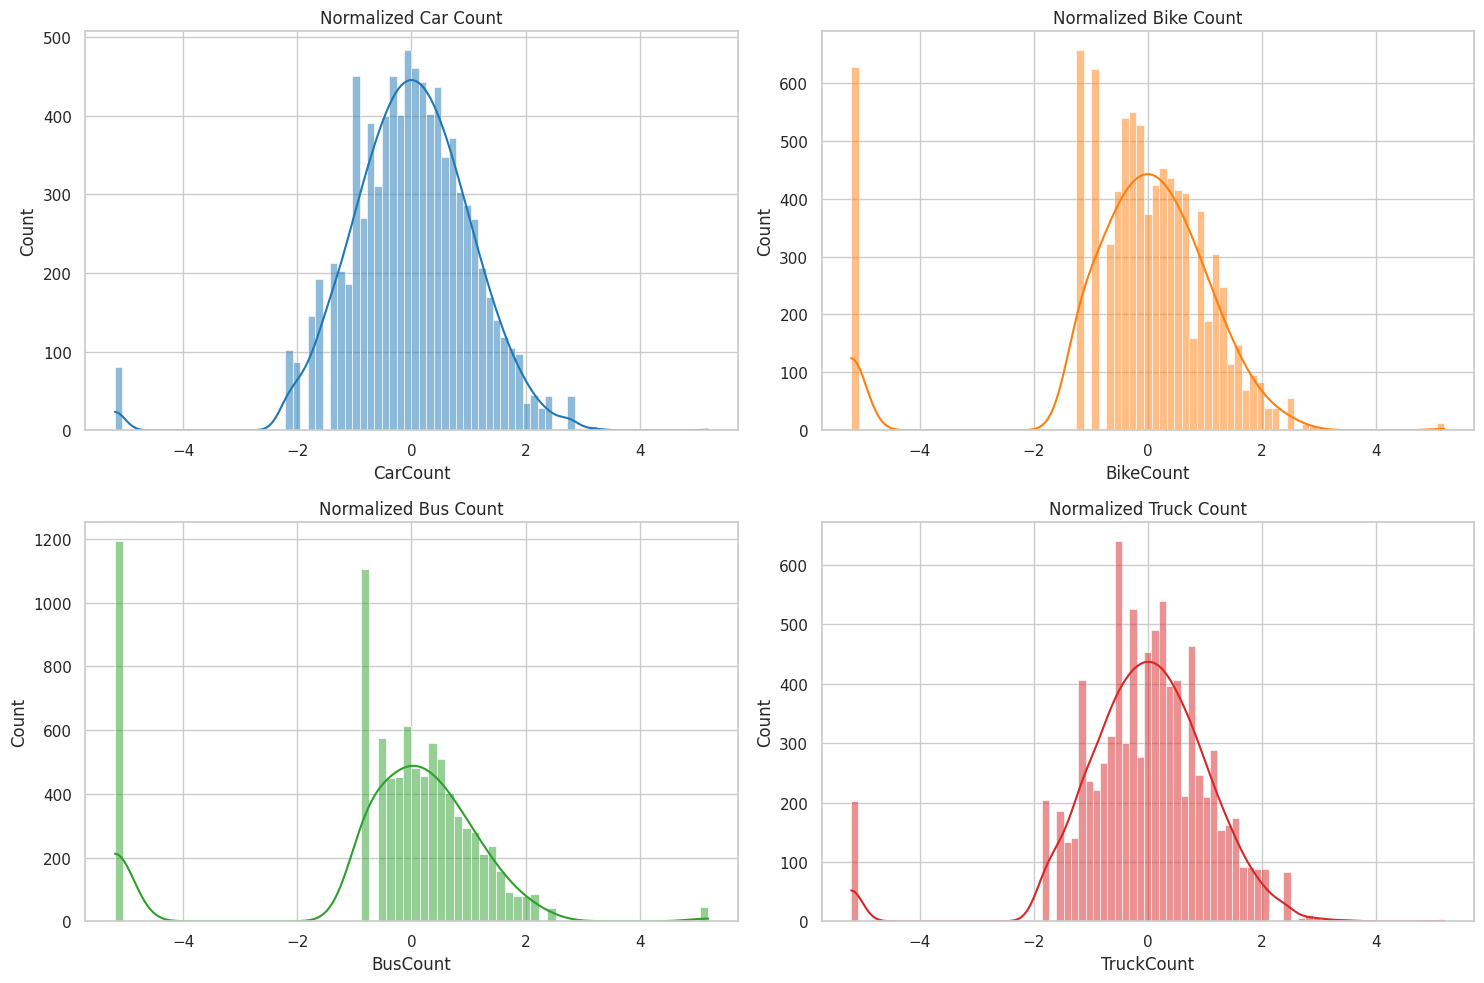

In [ ]:
# Check distribution after normalization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(combined_df['CarCount'], ax=axes[0, 0], kde=True, color='#1f77b4')
sns.histplot(combined_df['BikeCount'], ax=axes[0, 1], kde=True, color='#ff7f0e')
sns.histplot(combined_df['BusCount'], ax=axes[1, 0], kde=True, color='#2ca02c')
sns.histplot(combined_df['TruckCount'], ax=axes[1, 1], kde=True, color='#d62728')
axes[0, 0].set_title('Normalized Car Count')
axes[0, 1].set_title('Normalized Bike Count')
axes[1, 0].set_title('Normalized Bus Count')
axes[1, 1].set_title('Normalized Truck Count')
plt.tight_layout()
plt.show()

In [ ]:
# Feature engineering
combined_df['Hour'] = pd.to_datetime(combined_df['Time'], errors='coerce').dt.hour
combined_df['Day'] = pd.to_datetime(combined_df['Date'], errors='coerce').dt.day
combined_df['Month'] = pd.to_datetime(combined_df['Date'], errors='coerce').dt.month
combined_df['Weekend'] = combined_df['Day of the week'].isin(['Friday', 'Saturday']).astype(int)

<ipython-input-15-115961a1dd3a>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [ ]:
# Features
numeric_features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Hour', 'Day', 'Month']
categorical_features = ['Day of the week', 'Source']


In [ ]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
# Target encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(combined_df['Traffic Situation'])
X = combined_df[numeric_features + categorical_features]

In [ ]:
# تحويل الأعمدة النصية إلى أرقام باستخدام one-hot encoding
X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)


# Scale features for improved performance with SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Modeling (SVM)**





In [ ]:
# 0 = Heavy, 1 = High, 2 = Normal, 3 = Low
class_names = ['Heavy', 'High', 'Normal', 'Low']
kernels = ['linear', 'poly', 'rbf']
for kernel_type in kernels:
    print(f" Kernel: {kernel_type.upper()} ")
    svm_clf = SVC(kernel=kernel_type, random_state=42)
    svm_clf.fit(X_train_scaled, y_train)
    y_pred = svm_clf.predict(X_test_scaled)


 Kernel: LINEAR 
 Kernel: POLY 
 Kernel: RBF 


In [ ]:
# Hyperparameter Tuning
print("\n Hyperparameter Tuning for RBF Kernel ")
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

svm = SVC(random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


 Hyperparameter Tuning for RBF Kernel 
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV Score: 0.9286135502356965


In [ ]:
# Best Model Evaluation
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)

print("\n *Classification Report with Best Parameters* ")
print(classification_report(y_test, y_pred_best, target_names=class_names))


 *Classification Report with Best Parameters* 
              precision    recall  f1-score   support

       Heavy       0.94      0.98      0.96       326
        High       0.88      0.85      0.86       136
      Normal       0.90      0.85      0.87       228
         Low       0.95      0.95      0.95      1054

    accuracy                           0.94      1744
   macro avg       0.92      0.91      0.91      1744
weighted avg       0.94      0.94      0.94      1744



In [ ]:
# AUC-ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_score = best_svm.decision_function(X_test_scaled)

auc_roc = roc_auc_score(y_test_bin, y_score, average='weighted', multi_class='ovr')
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.9666715185279248


In [ ]:
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best, average='weighted')
recall = recall_score(y_test, y_pred_best, average='weighted')
f1 = f1_score(y_test, y_pred_best, average='weighted')

print(" Average Evaluation Metrics ")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

 Average Evaluation Metrics 
Accuracy:  0.9364
Precision: 0.9359
Recall:    0.9364
F1-Score:  0.9359


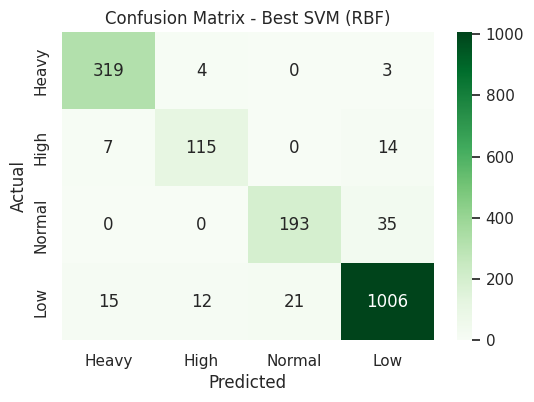

In [ ]:
# confusion matrics
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix - Best SVM (RBF)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


Model Comparison Summary:

           Model  Accuracy  Precision  Recall  F1 Score  AUC-ROC
0      SVM (RBF)    0.9364     0.9359  0.9364    0.9359   0.9667
1  Random Forest    0.9966     0.9966  0.9966    0.9966   0.9997
2            MLP    0.9868     0.9869  0.9868    0.9868   0.9992


<ipython-input-40-bb65f36c5c1a>:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-40-bb65f36c5c1a>:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-40-bb65f36c5c1a>:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




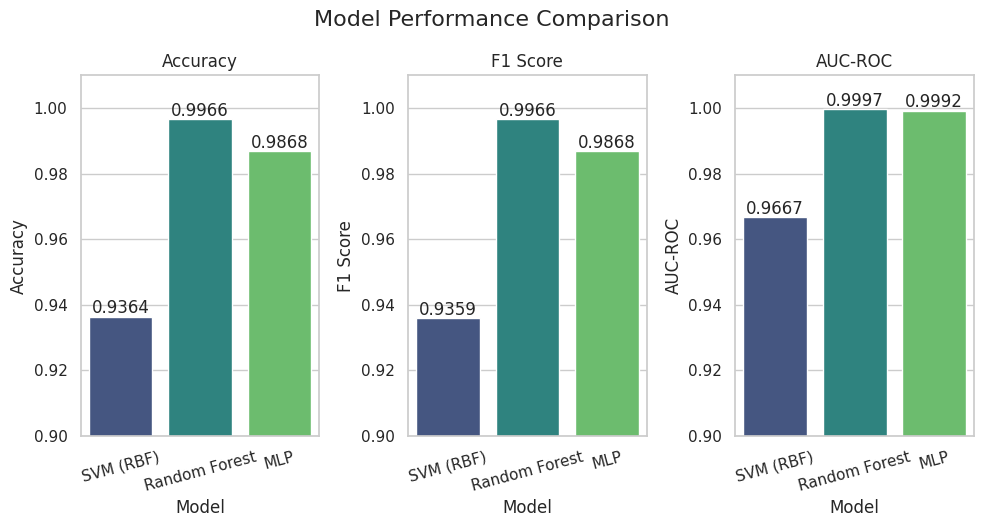

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


model_results = {
    'Model': ['SVM (RBF)', 'Random Forest', 'MLP'],
    'Accuracy': [0.9364, 0.9966, 0.9868],
    'Precision': [0.9359, 0.9966, 0.9869],
    'Recall': [0.9364, 0.9966, 0.9868],
    'F1 Score': [0.9359, 0.9966, 0.9868],
    'AUC-ROC': [0.9667, 0.9997, 0.9992]
}

# تحويلها إلى DataFrame
results_df = pd.DataFrame(model_results)


print("\nModel Comparison Summary:\n")
print(results_df)

# (Accuracy, F1, AUC-ROC)
plt.figure(figsize=(10, 5))
metrics = ['Accuracy', 'F1 Score', 'AUC-ROC']
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(data=results_df, x='Model', y=metric, palette='viridis')
    plt.title(metric)
    plt.xticks(rotation=15)
    plt.ylim(0.9, 1.01)
    for index, row in results_df.iterrows():
        plt.text(index, row[metric] + 0.001, f"{row[metric]:.4f}", ha='center')

plt.tight_layout()
plt.suptitle("Model Performance Comparison", fontsize=16, y=1.05)
plt.show()
